<p><img src="Signature_Stacked_Purple_Hex.png" alt="Drawing" style="width: 450px;float: right;"/>

### This Jupyter Notebook highlights the "Step-by-Step" analytic<br>procedures of a data science model to examine relationships<br>between vegetation and wildlife at Seattle's Discovery Park.<br>The sample data used in this notebook does not accurately reflect statistical correlations in Discovery Park's ecosystem because the Friends of Discovery Park is still collecting data to enable representative findings. This notebook should be considered a framework that will only produce interpretive findings once the first phase of data collection is complete.<br><br>Details regaring the background and rationale of this<br>analysis are presented in _"Friend of Discovery Park Virtual Management Platform (VMP) - Phase 2"_ <br>by Hall, Lewis, and Lin (2019), which is available for download<br>at: https://depts.washington.edu/mgis/capstone/capstone.html

<p><img src="FoDPscenery.png" alt="Drawing" hspace="10000" style="width: 225px;float: left;"/></p>

### &nbsp;&nbsp;&nbsp;The following libraries were used in this analysis:<br>&nbsp;&nbsp;&nbsp;1. [_arcpy_](https://pro.arcgis.com/en/pro-app/arcpy/get-started/a-quick-tour-of-arcpy.htm) *(must have license through ArcGIS, not open source)*<br>&nbsp;&nbsp;&nbsp;2. [_pandas_](https://pandas.pydata.org/)<br>&nbsp;&nbsp;&nbsp;3. [_numpy_](https://www.numpy.org/)<br>&nbsp;&nbsp;&nbsp;4. [_scikit-learn_](https://scikit-learn.org/stable/documentation.html)<br>&nbsp;&nbsp;&nbsp;5. [_os_](https://docs.python.org/3/library/os.html)<br>&nbsp;&nbsp;&nbsp;6. [_matplotlib_](https://matplotlib.org/) *(used to render findings, not to generate results)*

### &nbsp;&nbsp;&nbsp;__The following books were used to guide us through analayses:__<br>&nbsp;&nbsp;&nbsp;1. [_PYTHON Scripting for ArcGIS (by Paul A. Zandergen)_](https://esripress.esri.com/display/index.cfm?fuseaction=display&websiteID=276&moduleID=0)<br>&nbsp;&nbsp;&nbsp;2. [_Hands-On Machine Learning with Scikit-Learn & TensorFlow (by Aurélien Géron)_](http://shop.oreilly.com/product/0636920052289.do)

<font color=blue> Note(s): <br><br>Some Python3 libraries used in analyses may not be  compatitble with versions of libraries installed on other PCs. Please read output log to determine if pip installtion of additional libraries are needed to replicate this framework on other computers.<br><br>The easiest way to use the Jupyter-Notebook with the arcpy library is to use the pre-installed Jupyter-Notebook that comes with ArcGIS Desktop (i.e., Start button --> ArcGIS Folder--> Jupyter Notebook). If one prefers to operate Jupyter-Notebook from a particular directory one must navigate to: <br>1.  Start button --> ArcGIS Folder--> Python Command Prompt <br>2. Change directory where you want notebook located (e.g., "cd C:\Users\username\Documents\GEOG) <br>3. Type "jupyer notebook". <br><br>If one wants to pip install a library not preloaded with ArcGIS Desktop, one must navigate to: <br>1. Start button --> ArcGIS Folder--> (and right click on) Python Command Prompt --> select "open file location" <br>2. Right-click on "Python Command Prompt" and select "Run as Administrator" (note: you will not be able to install external libraries if you do not have administrative priveleges. As such, be very mindful of the libraries you install because not all libraries are useful and warrant installation. Only install reputable libraries) <br>3. Follow pip installation instructions in the library's documentation <br>4. change directory, if desired, and open Jupyter-Notebook.</font>

In [42]:
import arcpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import sklearn as sklearn
from matplotlib.ticker import FuncFormatter
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import os
import getpass 
from arcgis.gis import GIS
import sys
from arcgis.mapping import WebMap
from arcgis.features import SpatialDataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
direct="C:/Users/lewis/Documents/GEOG 569/"

## To fully replicate analyses highlighted in this notebook, you must have access to the Firends of Discovery Park AGOL account. Otherwise, you will not be able to live demo analyses.

In [2]:
u = getpass.getpass(prompt='Enter username')
p = getpass.getpass(prompt='Enter password')
gis = GIS('https://fodp.maps.arcgis.com/',u, p)

Enter username········
Enter password········


### As a reminder, we were asked to examine correlations between vegetation, wildlife, and health to help stakeholders gain an understanding of the ripple interactive relationships that could happen due to decisions focused on narrowly scoped objectives. Below is a webmap used in a presentation discussing [ecosystem affordances at Discovery Park](https://fodp.maps.arcgis.com/apps/MapJournal/index.html?appid=6f9efcf8e02547b39e576f484e04268d).

In [12]:
extent = gis.content.search(query = "cd853b7204fc4973a9f7129b2bd43cc7")
FoDPMap = WebMap(extent[0])
FoDPMap

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

### Early attempts in our exploratory analyses suggest that though the data in hand collected by [Rich, Peterson, and Marshall (2018)](https://depts.washington.edu/mgis/capstone/files/GEOG569_2018_Rich_Peterson_Marshall.pdf) was critical in our early endeavours, it did not appear sufficient to produce results generalizable to Discovery Parks diverse ecosystem. One issue in particular, which was a limiting factor was that though the bird data and vegetation data was somewhat decent, factors such as insects and other seed-based vegetative sources appeared missing. Not all birds are herbivores. As such we decided to focus on collecting data to make FoDP's analytic model more robust in the future.

### Moreover, though we were capable of doing many analytic data management techniques in Python, we used Microsoft SQL Server for most of the heavy-duty data management steps. This is important to share so that FoDP is aware of additional technological resources to bolster their analytic efforts. Ideally, FoDP would be allowed to archive data extracted from the ArcGIS online website in a database within a server used by Seattle's Park and Recreation. This would provide the advantage of 1) data back-up should FoDP decide not use ArcGIS anymore, 2) computational efficiency in the data management steps, and 3) the ability to use minimnal ArcGIS credits for analyses. The example SQL code below shows our attempt to calculate the number of birds with a 700 foot radius of ~49K hexbins in addition to other analytic steps (e.g., left joins, etc). This took 25 seconds on a SQL server database, but was taking well over 3 hours on a i7 laptop with 16GB of RAM.

<p><img src="SQLSnippet.png" alt="Drawing" style="width: 1250px;float: center;"/>

# Now let's review some input data for our models...

### Below is a "look-up" table highlightings findings from an Earth Economics' study providing financial estimates for various types of landcover given attributes such as: Aesthetics, Air Pollution, Carbon Sequestration, Disaster Mitigation, Health, Shelter, Waste, and Water. The columns "low" and "high" representing the estimated minimum and maximum value per acre of a given land type.

In [3]:
EE = pd.read_csv(direct+"EELookup.csv", 
                  encoding = "ISO-8859-1", 
                  error_bad_lines=False)
EE.head()

,Landcover,Agriculture,Riparian,Urban,valueType,low,high
0,Deciduous Forest,0,0,0,Aesthetic,341.707924,3183.294185
1,Deciduous Forest,1,0,0,Aesthetic,649.371412,649.371412
2,Deciduous Forest,0,1,0,Aesthetic,246.826680,1209.098061
3,Deciduous Forest,0,0,1,Aesthetic,263.322140,2135.288444
4,Deciduous Forest,1,1,0,Aesthetic,246.826680,1209.098061


### This table highlights a few attributes of interest with respect to our framework. First, we have landcover and hexbin grid identifiers (take note that some attributes are null). We also have columns representing the number of various species of birds seen in 2016 at various points in Discovery Park. We transformed this attribute by summing the number of birds within a 700 feet radious of each hexbin. Though our selected buffer distance requires future research, we believed that this approach is ideal because birds are fairly mobile animals, suggesting that standardizing the measure using a "neighborhood" approach is better than accepting a one-time snapshot as "the truth." We also spatially joined the categroization (1=yes, 0=no) of various vegetative species, as well as the Mangement Zone of the hexbin.

In [15]:
original = pd.read_csv(direct+"OriginalScenario.csv",
                       encoding = "ISO-8859-1",error_bad_lines=False)
original.head()

,OBJECTID,GRID_ID,LandCover,Acres,Carbon_Low,Carbon_High,Latitude,Longitude,AmericanRobin,AmericanCrow,BlackChickadee,SongSparrow,PineSiskin,MewGull,GoldenKinglet,Junco,AnnaHummingbird,AmericanGoldfinch,SpottedTowhee,BewickWren,ChestnutChickadee,GlaucousGull,PacificWren,EuropeanStarling,RubyKinglet,HouseFinch,Barren,bigLeafMaple,redAlder,Bentgrass,Quackgrass,douglasFir,bitterCherry,tallFescue,HimalayanBlackberry,CaliforniaBlacberry,scotchBroom,westernHemlock,westernRedCedar,skunkCabbage,pacificMadrone,Willow,Cattail,zoneMGT,LC,Agriculture,Riparian,Urban
0,255,IS-152,NaN,0.007986,0.467090,2.277808,245264.823900,1.250718e+06,39,20,29,22,37,2,42,53,31,17,16,10,24,0,4,33,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No Zone,NaN,NaN,NaN,NaN
1,3505,IE-139,NaN,0.011479,1.119828,5.460942,245575.142505,1.250424e+06,43,48,27,46,28,0,31,33,17,46,13,8,23,0,15,35,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No Zone,NaN,NaN,NaN,NaN
2,3674,IS-153,NaN,0.000255,NaN,NaN,245247.458449,1.250724e+06,39,20,29,22,37,2,42,53,31,17,16,10,24,0,4,33,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No Zone,NaN,NaN,NaN,NaN
3,4129,IT-151,NaN,0.011479,1.119834,5.460970,245298.819239,1.250736e+06,39,20,29,22,37,2,42,53,31,17,16,10,24,0,4,33,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No Zone,NaN,NaN,NaN,NaN
4,4152,IE-140,NaN,0.011479,1.119839,5.460994,245551.114338,1.250424e+06,43,48,27,46,28,0,31,33,17,46,13,8,23,0,15,35,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No Zone,NaN,NaN,NaN,NaN


### Now, we are going to statistically model the relationship between vegetation and bird wildlife. More specifically, we are going to build a model that attempts to predict the number of birds per 700 feet for each hexbin given changes in vegetation. We decided to use a RandomForest model because the model will likely get more complicated once more data is collected.

### We decinded not to impute data for this framework, so we will remove any observations with missing data in our  depedent (birds) and independent (vegetation) variables.

In [16]:
data=original[['AmericanRobin','AmericanCrow','BlackChickadee','SongSparrow',
               'PineSiskin','MewGull','GoldenKinglet','Junco','AnnaHummingbird','AmericanGoldfinch',
               'SpottedTowhee','BewickWren','ChestnutChickadee','GlaucousGull','PacificWren','EuropeanStarling',
               'RubyKinglet','HouseFinch','Barren','bigLeafMaple','redAlder','Bentgrass','Quackgrass',
               'douglasFir','bitterCherry','tallFescue','HimalayanBlackberry','CaliforniaBlacberry',
               'scotchBroom','westernHemlock','westernRedCedar','skunkCabbage','pacificMadrone','Willow','Cattail']]
null_data = data[data.isnull().any(axis=1)]
null_data
good_data = data[~data.isnull().any(axis=1)]
good_data = good_data.reset_index()
good_data.head()

,index,AmericanRobin,AmericanCrow,BlackChickadee,SongSparrow,PineSiskin,MewGull,GoldenKinglet,Junco,AnnaHummingbird,AmericanGoldfinch,SpottedTowhee,BewickWren,ChestnutChickadee,GlaucousGull,PacificWren,EuropeanStarling,RubyKinglet,HouseFinch,Barren,bigLeafMaple,redAlder,Bentgrass,Quackgrass,douglasFir,bitterCherry,tallFescue,HimalayanBlackberry,CaliforniaBlacberry,scotchBroom,westernHemlock,westernRedCedar,skunkCabbage,pacificMadrone,Willow,Cattail
0,0,39,20,29,22,37,2,42,53,31,17,16,10,24,0,4,33,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,43,48,27,46,28,0,31,33,17,46,13,8,23,0,15,35,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,39,20,29,22,37,2,42,53,31,17,16,10,24,0,4,33,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,39,20,29,22,37,2,42,53,31,17,16,10,24,0,4,33,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,43,48,27,46,28,0,31,33,17,46,13,8,23,0,15,35,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## For the first example we are going to model the influence of vegetation on the density of American Robins. The array outputted is the negative mean absolute error from the 10-fold cross validated model. 36% error is not great, but given the limited predictors that is to be expected. We used a cross-validation approach to test our model, which is why the "test_size" of our split is zero. Some prefer to use another approach to split the dataset into test and training datasets.

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(good_data[['Barren','bigLeafMaple','redAlder','Bentgrass','Quackgrass',
                                                               'douglasFir','bitterCherry','tallFescue','HimalayanBlackberry','CaliforniaBlacberry',
                                                               'scotchBroom','westernHemlock','westernRedCedar','skunkCabbage','pacificMadrone','Willow','Cattail']], 
                                                    good_data[['AmericanRobin']],
                                                    test_size=0.25,
                                                    random_state=226)

In [52]:
gsc = GridSearchCV(estimator=RandomForestRegressor(),
                   param_grid={'max_depth': range(3,30),
                               'n_estimators': (10, 50, 100, 1000),},
                   cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=1)
grid_result = gsc.fit(X_train, Y_train.values.ravel())
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],
                            random_state=False, verbose=False)
# Perform K-Fold CV
scores = cross_val_score(rfr, X_train, Y_train.values.ravel(), cv=10, scoring='neg_mean_absolute_error')
rfr.fit(X_train, Y_train.values.ravel())
scores

KeyboardInterrupt: 

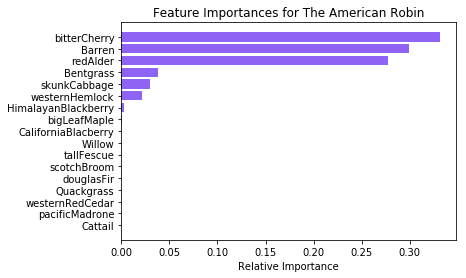

In [49]:
features = X_train.columns.values
importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances for The American Robin')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

## Now lets use the model to predict the number of American Robins given various scenarios where areas of Discovery Park are considered to be changed to "Barren" landtype to build shelters. Beneath the map is a preview of the hexbins that were modified. GRID_ID is our unique identifier and "name" represents that Discovery Park Management area.

In [34]:
#import the scenarios using pandas
scenario1 = pd.read_csv(direct+"Scenario1.csv",encoding = "ISO-8859-1",error_bad_lines=False)
scenario2 = pd.read_csv(direct+"Scenario2.csv",encoding = "ISO-8859-1",error_bad_lines=False)
scenario3 = pd.read_csv(direct+"Scenario3.csv",encoding = "ISO-8859-1",error_bad_lines=False)
scenario4 = pd.read_csv(direct+"Scenario4.csv",encoding = "ISO-8859-1",error_bad_lines=False)
scenario5 = pd.read_csv(direct+"Scenario5.csv",encoding = "ISO-8859-1",error_bad_lines=False)

#display the map showing extent of scenarios
scenario = gis.content.search(query = "102f0ba5e0764e05b0f1aa3107bc9367")
Modify = WebMap(scenario[0])
Modify

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [35]:
modifiedScenarios= pd.read_csv(direct+"ModifyScenarios.csv",encoding = "ISO-8859-1",error_bad_lines=False)
modifiedScenarios.head()

,OBJECTID,Join_Count,TARGET_FID,GRID_ID,LandCover,name,SceneDesc,Scenario
0,17,1,17,GM-207,Shrubland,Sludge Meadow,Bird Alley and Sludge Meadow,3
1,20,1,20,EN-192,Grassland,S. Bluff Forest Trail,Southern SouthBluff Forrest Trail,2
2,21,1,21,GH-201,Shrubland,Bird Alley,Bird Alley and Sludge Meadow,3
3,25,1,25,GM-210,Grassland,Sludge Meadow,Bird Alley and Sludge Meadow,3
4,27,1,27,GZ-197,Grassland,Sludge Meadow,Bird Alley and Sludge Meadow,3


In [53]:
scenario1['pred_AmericanRobin'] = rfr.predict(scenario1[['Barren','bigLeafMaple','redAlder','Bentgrass','Quackgrass',
                       'douglasFir','bitterCherry','tallFescue','HimalayanBlackberry',
                       'CaliforniaBlacberry','scotchBroom','westernHemlock','westernRedCedar',
                       'skunkCabbage','pacificMadrone','Willow','Cattail']])
AmericanRobin1 = pd.DataFrame(data=Model1.flatten())

Model2 = rfr.predict(scenario2[['Barren','bigLeafMaple','redAlder','Bentgrass','Quackgrass',
                       'douglasFir','bitterCherry','tallFescue','HimalayanBlackberry',
                       'CaliforniaBlacberry','scotchBroom','westernHemlock','westernRedCedar',
                       'skunkCabbage','pacificMadrone','Willow','Cattail']])
AmericanRobin2 = pd.DataFrame(data=Model2.flatten())
Model3 = rfr.predict(scenario3[['Barren','bigLeafMaple','redAlder','Bentgrass','Quackgrass',
                       'douglasFir','bitterCherry','tallFescue','HimalayanBlackberry',
                       'CaliforniaBlacberry','scotchBroom','westernHemlock','westernRedCedar',
                       'skunkCabbage','pacificMadrone','Willow','Cattail']])
AmericanRobin3 = pd.DataFrame(data=Model3.flatten())
Model4 = rfr.predict(scenario4[['Barren','bigLeafMaple','redAlder','Bentgrass','Quackgrass',
                       'douglasFir','bitterCherry','tallFescue','HimalayanBlackberry',
                       'CaliforniaBlacberry','scotchBroom','westernHemlock','westernRedCedar',
                       'skunkCabbage','pacificMadrone','Willow','Cattail']])
AmericanRobin4 = pd.DataFrame(data=Model4.flatten())
Model5 = rfr.predict(scenario5[['Barren','bigLeafMaple','redAlder','Bentgrass','Quackgrass',
                       'douglasFir','bitterCherry','tallFescue','HimalayanBlackberry',
                       'CaliforniaBlacberry','scotchBroom','westernHemlock','westernRedCedar',
                       'skunkCabbage','pacificMadrone','Willow','Cattail']])
AmericanRobin5 = pd.DataFrame(data=Model5.flatten())

# AmericanRobin5.head(1000)

### How will we connect the newly collected data into the model?
#### First, we will need to import data from a cloud. Then, we will need to extract that data source into a dataframe. Thereafter, these tables will be avilable to include in the analyses

In [59]:
collectorData = gis.content.search("69dc945e201a4e928a485991fb2d164f")
collect = WebMap(collectorData[0])
collect

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [74]:
collect_dataset = collect.layers[0]
collect_dataset
# collect= SpatialDataFrame.from_layer(collect_dataset)
# collect.head()
# collect_dataset
# collect = collect_dataset.df


{
  "id": "Data_Collection_Layer_8561",
  "layerType": "ArcGISFeatureLayer",
  "url": "https://services8.arcgis.com/oPUUsmOGorTdleDq/arcgis/rest/services/Data_Collection_Layer/FeatureServer/0",
  "visibility": true,
  "opacity": 1,
  "title": "Data Collection Layer",
  "itemId": "7200efbc3a2a4648b0d363695f23feb5"
}

<Item title:"Discovery Park Recreation Survey 1" type:Feature Layer Collection owner:FoDP1974>
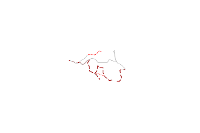

In [79]:
collect = gis.content.search("Data Collection Layer")
collect[6]